# EZBattery demo
------------------------------------------
## Vanadium redox flow battery
------------------------------------------
## Table of contents
### 1. Import all the necessary packages
### 2. Load in the cell metadata
### 3. Load in the experiment data
### 4. Model calibration
#### 4.1. Adjust the parameters for the single cycle calibration
#### 4.2. Run the auto calibration for the first cycle
#### 4.3 Show the model estimation for the firt cycle performance with the calibrated cell properties
#### 4.4 Adjust the setup for multiple cycle calibration
#### 4.5 Run the calibration for the first three cycles
#### 4.6 Show the results for the first three cycles with the calibrated properties. Users can directly use the values here if the calibrittion is not completed
#### 4.7 Run the model for 41 cycles with cross-contamination

### 1. Import all the necessary packages

In [1]:
import os, copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from EZBattery import BatteryParameter,LoadExperiment, RFB
from EZBattery import Calibration, CellLossFunction

### 2. Load in the cell metadata

In [2]:
WorkDir = os.getcwd() + os.sep + 'data' 
SDPFNames = 'SDPF_Vanadium_20240718_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFNames
PP = BatteryParameter(SDPFPath)

### 3. Load in the experiment data

In [3]:
PP0 = copy.deepcopy(PP)
PP0.CalibrationOutputPath = SDPFPath
fname = PP0.Experiment.split('\\')[-1]
EXPPath = WorkDir + os.sep + fname
PP0.Experiment = EXPPath
F = LoadExperiment(PP0)

Loading experiment data from D:\ROVI\EZBattery_python\EZBattery_Demo\EZBattery_Demo\data\Bin-2-2-5V-N115-0_05NbW-02152013-3.xlsx.


### 4. Model calibration
#### 4.1. Adjust the parameters for the single cycle calibration. 
##### In this example, four cell properties are selected for calibrtion to make the model prediction matching the experiment data better. 
1) mass transport coefficient in porous electrode (0.1-100)
2) membrane conductivity (0.01-2)
3) reaction rate constant in anode side (1e-9 - 1e-6)
4) reaction rate constant in cathode side (1e-9 - 1e-6)

In [4]:
PP0.Display = 'no'
PP0.SolverType = 'ODEImplicit'
PP0.TimeStep = 1000
PP0.RefineTimePoints = 1
PP0.RefineTimeTimes = 1      
PPS = copy.deepcopy(PP0)
PPS.NumberOfProcessor = 1
PPS.MaxIteration = 25
PPS.PopulationSize = 8
PPS.CalibrationCycleStart = 1
PPS.CalibrationCycleEnd = 1
PPS.BoundsSingle = [(0.1,100),(0.01,2),(1e-9,1e-6),(1e-9,1e-6)]
PPS.DisplayDifferentialEvolution = 'yes'
PPS.CalibrationDisplay = 'no'
PPS.CalibrationDisplayDebug = 'no'
PPS.CalibrationMode = 'Single'
PPS.DecayMode = 'None'

#### 4.2. Run the auto calibration for the first cycle

In [5]:
PPS.CalibrationDisplay = 'no'
Res0 = Calibration(PPS, F)
PPS.TimeStep = 10
Rec0 = CellLossFunction(Res0.x,PPS,F)
x0 = Res0.x


EZBattery calibration for cycle 1.
differential_evolution step 1: f(x)= 4365.93
Solution: [3.91842676e+01 1.17436245e+00 8.08201882e-09 9.53796567e-07], Convergence: 0.0706488977525563
differential_evolution step 2: f(x)= 4365.93
Solution: [3.91842676e+01 1.17436245e+00 8.08201882e-09 9.53796567e-07], Convergence: 0.07398226986678252
differential_evolution step 3: f(x)= 4033.28
Solution: [3.01313609e+01 1.08982791e+00 7.58259934e-09 9.37728925e-07], Convergence: 0.06064218820541263
differential_evolution step 4: f(x)= 4033.28
Solution: [3.01313609e+01 1.08982791e+00 7.58259934e-09 9.37728925e-07], Convergence: 0.06134103853093054
differential_evolution step 5: f(x)= 4033.28
Solution: [3.01313609e+01 1.08982791e+00 7.58259934e-09 9.37728925e-07], Convergence: 0.059923412896232056
differential_evolution step 6: f(x)= 4033.28
Solution: [3.01313609e+01 1.08982791e+00 7.58259934e-09 9.37728925e-07], Convergence: 0.05863614572433492
differential_evolution step 7: f(x)= 1334.69
Solution: [1.

#### 4.3 Show the model estimation for the first cycle performance with the calibrated cell properties
##### User can directly try the calibrated properties 
x0 = [4.44106325e+01, 2.81156609e-01, 3.36383873e-07, 3.79733814e-09]

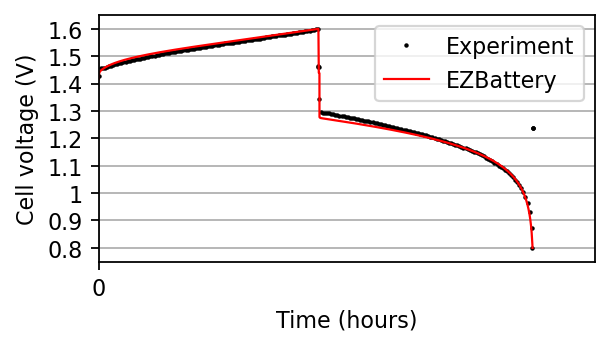

In [8]:
PPS.CathodeMassTransportCoefficient = x0[0]
PPS.AnodeMassTransportCoefficient = x0[0]
PPS.MembraneIonDragCoefficient = x0[1]
PPS.CathodeReactionRateConstant = x0[2]
PPS.AnodeReactionRateConstant = x0[3]
PPS.CycleNumber = 1
Re0=RFB(PPS)
ncx=1
sd=3600
FV = F[F[:,3]<=ncx,:]
plt.figure(figsize=(4,2),dpi=160)
plt.plot(FV[:,0]/sd, FV[:, 1],'o',color='black',mfc='none',markersize=1,markevery=1,label="Experiment",linewidth=2)
plt.plot(Re0['Potentials']['Time_s']/sd,Re0['Potentials']['Ec_V'],'-',color='red',label='EZBattery',markersize=1,linewidth=1)

plt.xlabel('Time (hours)')
plt.ylabel('Cell voltage (V)')
tmax =  int(np.ceil(max(Re0['Potentials']['Time_s'])/sd) + 0)
n_labels_x = int(np.ceil(tmax/ncx*2))

labels_x = np.arange(0,tmax,n_labels_x)
labels_y = np.arange(0.8,1.7,0.1)
plt.xticks(labels_x, labels_x)
plt.yticks(labels_y, labels_y)
ax = plt.gca()
ax.set_xlim([0,tmax])
ax.set_ylim([0.75,1.65])
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.grid()
plt.legend() 
plt.show()
plt.close()


#### 4.4 Adjust the setup for multiple cycle calibration
##### The model considers the vanadium cross contamination
##### The calirating properties are:
1) Mass Transport Coefficient (0.1-10)
3) Membrane Ion Drag Coefficient (0.01-2)
4) Anode Reductant Partition Coefficient (0.0001-0.2)
5) Anode Oxidant Partition Coefficient (0.0001-0.2)
6) Cathode Reductant Partition Coefficient (0.0001-0.2)
7) Cathode Oxidant Partition Coefficient (0.0001-0.2)
##### To make this demo runing fast, the example only calibrate the first three cycles to impliment the calibration. If more cycles needed to be calibrated, change the parameter "PPM.CalibrationCycleEnd = 3" to higher number. 
##### The calibration is based on Differential Evolution approach. It can run in multi-thread mode to accelerate the speed. However, in Jupyter Notebook, the multi-thread feature may not work approperiately. Therefore, the example here only use single thread as a demo. For testing on multi-thread, please copy the code to a separate python script file, change PPM.workers to higher number, and direclty run it.

In [9]:
PPM = copy.deepcopy(PP0)
PPM.NumberOfProcessor = 1
PPM.TimeStep = 1000
PPM.PopulationSize = 8
PPM.CalibrationCycleStart = 1
PPM.CalibrationCycleEnd = 3

PPM.MaxIteration = 25
PPM.BoundsMultiple = [(0.1,10),(0.01,2),(0.0001,0.2),(0.0001,0.2),(0.0001,0.2),(0.0001,0.2)]
PPM.CalibratedReactionRateConstant = x0[2:4]                               # Using calibrated rate for multiple cycle.
PPM.DisplayDifferentialEvolution = 'yes'
PPM.CalibrationDisplay = 'no'
PPM.CalibrationDisplayDebug = 'no'
PPM.CalibrationType =  'run'
PPM.CalibrationMode = 'Multiple'
PPM.DecayMode = 'All'

#### 4.5 Run the calibration for the first three cycles

In [10]:
Res1 = Calibration(PPM, F)
PPM.CalibrationDisplay = 'yes'
PPM.TimeStep = 10
PPM.CathodeReactionRateConstant = x0[2]
PPM.AnodeReactionRateConstant = x0[3]
Rec1 = CellLossFunction(Res1.x, PPM, F)
x1 = Res1.x


EZBattery calibration for cycles 1 - 3
differential_evolution step 1: f(x)= 109.901
Solution: [3.98873083 1.07883721 0.19602655 0.05858571 0.06503908 0.12840223], Convergence: 0.017525368629845814
differential_evolution step 2: f(x)= 109.901
Solution: [3.98873083 1.07883721 0.19602655 0.05858571 0.06503908 0.12840223], Convergence: 0.018579959558823862
differential_evolution step 3: f(x)= 109.901
Solution: [3.98873083 1.07883721 0.19602655 0.05858571 0.06503908 0.12840223], Convergence: 0.02148179503620569
differential_evolution step 4: f(x)= 93.5462
Solution: [3.00312459 1.17448785 0.18402443 0.05392075 0.11189675 0.17086183], Convergence: 0.02121009688054367
differential_evolution step 5: f(x)= 93.1791
Solution: [4.27344453 1.16008919 0.16282125 0.13706223 0.18147115 0.1462943 ], Convergence: 0.022066782129761327
differential_evolution step 6: f(x)= 93.1791
Solution: [4.27344453 1.16008919 0.16282125 0.13706223 0.18147115 0.1462943 ], Convergence: 0.02772365817333741
differential_ev

#### 4.6 Show the results for the first three cycles with the calibrated properties. Users can directly use the values here if the calibrittion is not completed.
x1 = [1.60572269e+00 ,8.49979683e-01 ,7.53275142e-04 ,7.48834988e-02,3.07471066e-04 ,1.74687539e-03]

Running a multi-cycle unit cell model.
Active species: ['Vanadium4', 'Vanadium5', 'Vanadium3', 'Vanadium2'].
Non active species: ['Water', 'Proton'].
Cycle 1: charge 1.851 h, discharge 1.735 h, CE: 0.937, Cumulative CE 0.937 (2.2%).
Cycle 2: charge 1.784 h, discharge 1.711 h, CE: 0.959, Cumulative CE 0.924 (4.3%).
Cycle 3: charge 1.759 h, discharge 1.687 h, CE: 0.959, Cumulative CE 0.911 (6.3%).
Computation done, elapsed time 1.492 seconds, average time per cycle 0.497332 seconds.



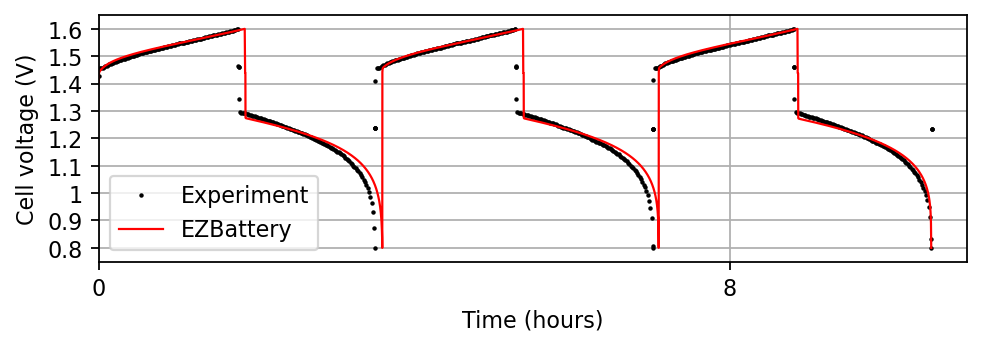

In [11]:
#%% Re-computing voltage based on calibrated parameters.
PP.Display = 'yes'
ncx = 3
param0 = x0
PPA = copy.deepcopy(PP)
PPA.TimmeStep = 10
PPA.CycleNumber = 1
PPA.DecayMode = 'None'
PPA.CathodeMassTransportCoefficient = param0[0]
PPA.AnodeMassTransportCoefficient = param0[0]
PPA.MembraneIonDragCoefficient = param0[1]
PPA.CathodeReactionRateConstant = param0[2]
PPA.AnodeReactionRateConstant = param0[3]

param1 = x1
PPB = copy.deepcopy(PP)
PPB.TimeStep = 10
PPB.CycleNumber = ncx
PPB.DecayMode = 'All'
PPB.CathodeReactionRateConstant = param0[2]
PPB.AnodeReactionRateConstant = param0[3]
PPB.CathodeMassTransportCoefficient = param1[0]
PPB.AnodeMassTransportCoefficient = param1[0]
PPB.MembraneIonDragCoefficient = param1[1]
PPB.AnodeReductant1PartitionCoefficient = param1[2]
PPB.AnodeOxidant1PartitionCoefficient = param1[3]
PPB.CathodeReductant1PartitionCoefficient = param1[4]
PPB.CathodeOxidant1PartitionCoefficient = param1[5]
Re2 = RFB(PPB)

sd = 3600
ncx=3
FV = F[F[:,3]<=ncx,:]
plt.figure(figsize=(7,2),dpi=160)
plt.plot(FV[:,0]/sd, FV[:, 1],'o',color='black',mfc='none',markersize=1,markevery=1,label="Experiment",linewidth=1)
plt.plot(Re2['Potentials']['Time_s']/sd,Re2['Potentials']['Ec_V'],'-',color='red',label='EZBattery',markersize=1,linewidth=1)

plt.xlabel('Time (hours)')
plt.ylabel('Cell voltage (V)')
tmax = int(np.ceil(max(Re2['Potentials']['Time_s'])/sd) + 0)
n_labels_x = int(np.ceil(tmax/ncx*2))

labels_x = np.arange(0,tmax,n_labels_x)
labels_y = np.arange(0.8,1.7,0.1)
plt.xticks(labels_x, labels_x)
plt.yticks(labels_y, labels_y)
ax = plt.gca()
ax.set_xlim([0,tmax])
ax.set_ylim([0.75,1.65])
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.grid()
plt.legend() 
plt.show()
plt.close()

#### 4.7 Run the model for 41 cycles with cross-contamination
#### User can directly use the pre-calibrated values here to compare the mode prediction and the experiment data. 
x0 = [4.44106325e+01, 2.81156609e-01, 3.36383873e-07, 3.79733814e-09] ; x1 = [7.67130304e+00 ,7.20051406e-01 ,1.23000523e-02 ,8.44809920e-03,2.12294362e-03, 1.45984843e-02]

Running a multi-cycle unit cell model.
Active species: ['Vanadium4', 'Vanadium5', 'Vanadium3', 'Vanadium2'].
Non active species: ['Water', 'Proton'].
Cycle 1: charge 1.818 h, discharge 1.767 h, CE: 0.972, Cumulative CE 0.972 (2.2%).
Cycle 2: charge 1.772 h, discharge 1.767 h, CE: 0.997, Cumulative CE 0.972 (4.3%).
Cycle 3: charge 1.771 h, discharge 1.766 h, CE: 0.997, Cumulative CE 0.971 (6.4%).
Cycle 4: charge 1.770 h, discharge 1.765 h, CE: 0.997, Cumulative CE 0.971 (8.5%).
Cycle 5: charge 1.769 h, discharge 1.764 h, CE: 0.997, Cumulative CE 0.970 (10.7%).
Cycle 6: charge 1.769 h, discharge 1.763 h, CE: 0.997, Cumulative CE 0.970 (12.8%).
Cycle 7: charge 1.768 h, discharge 1.762 h, CE: 0.997, Cumulative CE 0.969 (14.9%).
Cycle 8: charge 1.767 h, discharge 1.761 h, CE: 0.997, Cumulative CE 0.969 (17.0%).
Cycle 9: charge 1.766 h, discharge 1.760 h, CE: 0.997, Cumulative CE 0.968 (19.2%).
Cycle 10: charge 1.765 h, discharge 1.759 h, CE: 0.997, Cumulative CE 0.968 (21.3%).
Cycle 11: cha

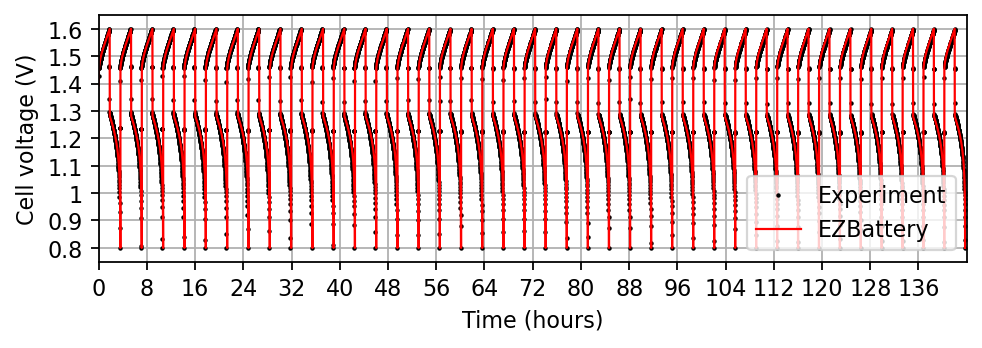

In [12]:
ncx = 41
x0 = [4.44106325e+01, 2.81156609e-01, 3.36383873e-07, 3.79733814e-09]
x1 = [7.67130304e+00 ,7.20051406e-01 ,1.23000523e-02 ,8.44809920e-03,2.12294362e-03, 1.45984843e-02]
param0 = x0
param1 = x1
PPB = copy.deepcopy(PP)
PPB.TimeStep = 10
PPB.CycleNumber = ncx
PPB.DecayMode = 'All'
PPB.CathodeReactionRateConstant = param0[2]
PPB.AnodeReactionRateConstant = param0[3]
PPB.CathodeMassTransportCoefficient = param1[0]
PPB.AnodeMassTransportCoefficient = param1[0]
PPB.MembraneIonDragCoefficient = param1[1]
PPB.AnodeReductant1PartitionCoefficient = param1[2]
PPB.AnodeOxidant1PartitionCoefficient = param1[3]
PPB.CathodeReductant1PartitionCoefficient = param1[4]
PPB.CathodeOxidant1PartitionCoefficient = param1[5]
Re3 = RFB(PPB)

sd = 3600
FV = F[F[:,3]<=ncx,:]
plt.figure(figsize=(7,2),dpi=160)
plt.plot(FV[:,0]/sd, FV[:, 1],'o',color='black',mfc='none',markersize=1,markevery=1,label="Experiment",linewidth=1)
plt.plot(Re3['Potentials']['Time_s']/sd,Re3['Potentials']['Ec_V'],'-',color='red',label='EZBattery',markersize=1,linewidth=1)

plt.xlabel('Time (hours)')
plt.ylabel('Cell voltage (V)')
tmax = int(np.ceil(max(Re3['Potentials']['Time_s'])/sd) + 0)
n_labels_x = int(np.ceil(tmax/ncx*2))

labels_x = np.arange(0,tmax,n_labels_x)
labels_y = np.arange(0.8,1.7,0.1)
plt.xticks(labels_x, labels_x)
plt.yticks(labels_y, labels_y)
ax = plt.gca()
ax.set_xlim([0,tmax])
ax.set_ylim([0.75,1.65])
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.grid()
plt.legend() 
plt.show()
plt.close()